# Data Manipulation

Optimization of CER comunity
starting from the optimization between load and production for a village

## Import Data Production (PVGIS)

In [11]:
#importing libraries

import pandas as pd
import os
import pyomo.environ as pyo 
import numpy  as np
import matplotlib.pyplot as plt
import datetime
import gurobipy as gp
from gurobipy import GRB
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"


Import of Solar irradiance from PVGIS
We take into account three different installation: South, East, West side of the roof

In [12]:
DF_name = "2019_ProductionEast.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_East = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0,parse_dates=[0])
DF_East


,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
20190101:0010,0.0,0.0,0.0,-1.91,2.14,0.0
20190101:0110,0.0,0.0,0.0,-2.68,2.14,0.0
20190101:0210,0.0,0.0,0.0,-2.98,2.07,0.0
20190101:0310,0.0,0.0,0.0,-3.06,2.00,0.0
20190101:0410,0.0,0.0,0.0,-3.47,1.93,0.0
...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,1.76,1.03,0.0
20191231:2010,0.0,0.0,0.0,1.36,1.03,0.0
20191231:2110,0.0,0.0,0.0,0.79,1.03,0.0


In [13]:
DF_name = "2019_ProductionSouth.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_South = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0,parse_dates=[0])
DF_South

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
20190101:0010,0.0,0.0,0.0,-1.91,2.14,0.0
20190101:0110,0.0,0.0,0.0,-2.68,2.14,0.0
20190101:0210,0.0,0.0,0.0,-2.98,2.07,0.0
20190101:0310,0.0,0.0,0.0,-3.06,2.00,0.0
20190101:0410,0.0,0.0,0.0,-3.47,1.93,0.0
...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,1.76,1.03,0.0
20191231:2010,0.0,0.0,0.0,1.36,1.03,0.0
20191231:2110,0.0,0.0,0.0,0.79,1.03,0.0


In [14]:
DF_name = "2019_ProductionWest.csv"
DF_path = os.path.join(Data_path_Production, DF_name)
DF_West = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0,parse_dates=[0])
DF_West

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
20190101:0010,0.0,0.0,0.0,-1.91,2.14,0.0
20190101:0110,0.0,0.0,0.0,-2.68,2.14,0.0
20190101:0210,0.0,0.0,0.0,-2.98,2.07,0.0
20190101:0310,0.0,0.0,0.0,-3.06,2.00,0.0
20190101:0410,0.0,0.0,0.0,-3.47,1.93,0.0
...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,1.76,1.03,0.0
20191231:2010,0.0,0.0,0.0,1.36,1.03,0.0
20191231:2110,0.0,0.0,0.0,0.79,1.03,0.0


Merge of all the Irradiances from the three configurations

In [15]:
DF_East = pd.concat([DF_East, DF_South["G(i)"].rename("G(i)_South")],axis=1)
DF_East = pd.concat([DF_East, DF_West["G(i)"].rename("G(i)_West")],axis=1)
DF_East.rename(columns={"G(i)": "G(i)_East"}, inplace=True)
DF_East.drop(columns=['P','H_sun','T2m','WS10m','Int'],inplace=True)
DF_Production = DF_East


Initialize the variables needed for the approximation of the production of PV panels starting from Irradiance Datas

In [16]:
# Percentage of PV panels installed for the specific orientation
percentage_south = 0.5
percentage_east = 0.25
percentage_west = 0.25



In [17]:
DF_Production.insert(3,"Tot_Production [W/m2]", DF_Production.loc[:,"G(i)_East"]* percentage_east  + DF_Production.loc[:,"G(i)_West"]*percentage_west + DF_Production.loc[:,"G(i)_South"]*percentage_south)
DF_Production

,G(i)_East,G(i)_South,G(i)_West,Tot_Production [W/m2]
time,,,,
20190101:0010,0.0,0.0,0.0,0.0
20190101:0110,0.0,0.0,0.0,0.0
20190101:0210,0.0,0.0,0.0,0.0
20190101:0310,0.0,0.0,0.0,0.0
20190101:0410,0.0,0.0,0.0,0.0
...,...,...,...,...
20191231:1910,0.0,0.0,0.0,0.0
20191231:2010,0.0,0.0,0.0,0.0
20191231:2110,0.0,0.0,0.0,0.0


## Import Data Consumption (Risolutore)

Import of consumption curves for residential, industrial and commercial units taken from Prof. data (Risolutore)

In [18]:
DF_name = "2019_ConsumptionCurve.csv"
DF_path = os.path.join(Data_path_Consumption, DF_name)
DF = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
DF


,Residential,Industrial,Commercial
time,,,
20190101:0010,1.1646,3.7287,7.7107
20190101:0110,1.1228,3.7306,7.4336
20190101:0210,1.0765,3.6858,7.1273
20190101:0310,1.0563,3.6483,6.9937
20190101:0410,1.0584,3.7366,7.0076
...,...,...,...
20191231:1910,1.6667,4.8134,11.0347
20191231:2010,1.5025,4.2607,9.9473
20191231:2110,1.4057,3.9699,9.3068


## Merge the DF

In [19]:
DF_Production.insert(4,'C_Residential', DF.loc[:,'Residential'])
DF_Production.insert(4,'C_Industrial', DF.loc[:,'Industrial'])
DF_Production.insert(4,'C_Commercial', DF.loc[:,'Commercial'])
DF_Production


,G(i)_East,G(i)_South,G(i)_West,Tot_Production [W/m2],C_Commercial,C_Industrial,C_Residential
time,,,,,,,
20190101:0010,0.0,0.0,0.0,0.0,7.7107,3.7287,1.1646
20190101:0110,0.0,0.0,0.0,0.0,7.4336,3.7306,1.1228
20190101:0210,0.0,0.0,0.0,0.0,7.1273,3.6858,1.0765
20190101:0310,0.0,0.0,0.0,0.0,6.9937,3.6483,1.0563
20190101:0410,0.0,0.0,0.0,0.0,7.0076,3.7366,1.0584
...,...,...,...,...,...,...,...
20191231:1910,0.0,0.0,0.0,0.0,11.0347,4.8134,1.6667
20191231:2010,0.0,0.0,0.0,0.0,9.9473,4.2607,1.5025
20191231:2110,0.0,0.0,0.0,0.0,9.3068,3.9699,1.4057


In [20]:
DF_Production.loc[:,"Tot_Production [W/m2]"].to_csv("C:/Users/Nik/Documents/GitHub/Thesis/CSV/Prova2.csv")

# Model with fixed Consumption m2 and continous variables

Set parameter MIPGap to value 0.005
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5 rows, 4 columns and 11 nonzeros
Model fingerprint: 0x83c1aac4
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [8e+04, 6e+06]
  RHS range        [8e+04, 2e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3 rows and 2 columns
Presolve time: 0.01s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.614833e+05   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal obj

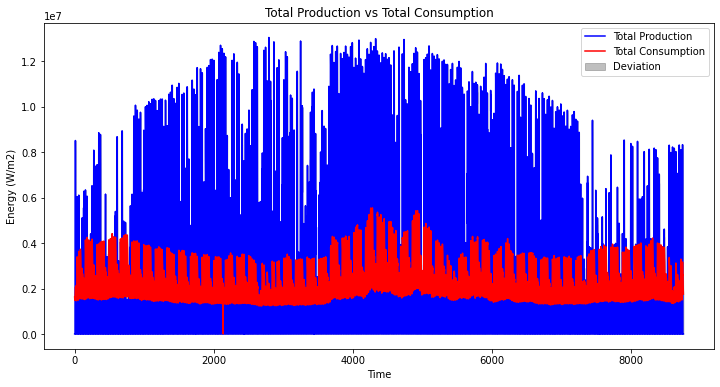

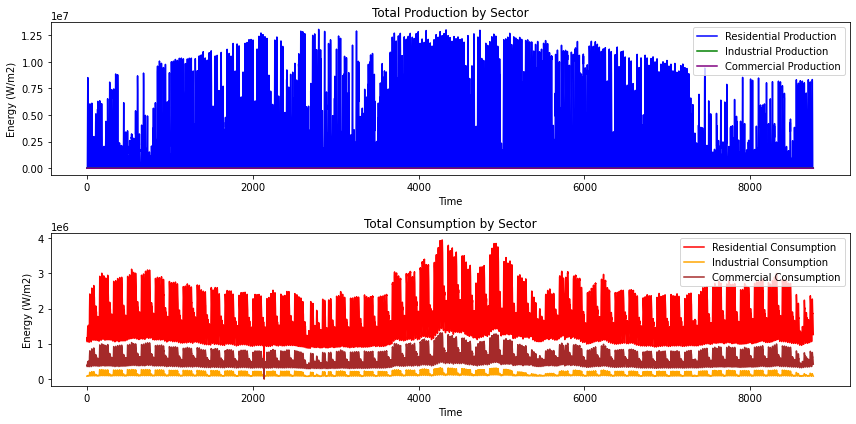

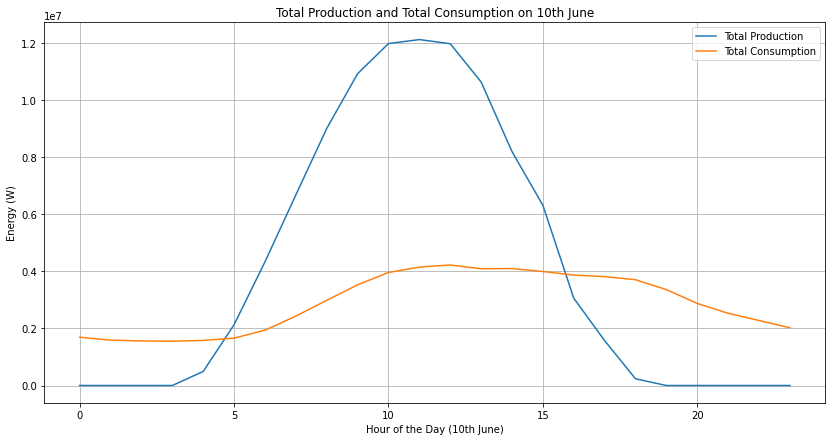

In [83]:
# Constants
DoublePitched = 0.5 * 0.6 * 0.85 * 0.7 * 0.5
Industrial = 0.8 * 0.9 * 1 * 0.45 * 1 * 0.45 * 1
Flat = 1 * 0.6 * 0.9 * 0.45 * 0.5
costheta_Res = np.cos(20 * np.pi / 180)
costheta_Ind = np.cos(30 * np.pi / 180)
costheta_Com = np.cos(0 * np.pi / 180)
CoefRes = (DoublePitched * 0.95 + Flat * 0.05) / costheta_Res
CoefInd = Industrial / costheta_Ind
CoefCom = (Flat * 0.5 + DoublePitched * 0.5) / costheta_Com
Area_Res_Max = 6360957.13  # m2 from QGIS
Area_Ind_Max = 78341.55  # m2 from QGIS
Area_Com_Max = 210725.647  # m2 from QGIS

# Dictionary for coefficients of roof
Roof_type = {'P_Residential': CoefRes, 'P_Industrial': CoefInd, 'P_Commercial': CoefCom}
Area_Max = {'Area_Res_Max': 6360957.13, 'Area_Ind_Max': 78341.55, 'Area_Com_Max': 210725.647}  # m2 from QGIS
yearlist = DF_Production.index.to_list()

# Create a new Gurobi model
m = gp.Model("optimization_model")

# Production Variables
RP = m.addVar(lb=0, ub=Area_Res_Max, vtype=GRB.CONTINUOUS, name="RP")
IP = m.addVar(lb=0, ub=Area_Ind_Max, vtype=GRB.CONTINUOUS, name="IP")
CP = m.addVar(lb=0, ub=Area_Com_Max, vtype=GRB.CONTINUOUS, name="CP")

#Consumptions
RC_value = 1000000
IC_value = 20000
CC_value = 50000

# Auxiliary variable for absolute deviation
deviation = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to guide solver towards a non-zero solution
RP.start = 1
IP.start = 1
CP.start = 1

# Objective function components
TotProdRes = gp.quicksum(RP * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Residential'] for t in yearlist)
TotProdInd = gp.quicksum(IP * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Industrial'] for t in yearlist)
TotProdCom = gp.quicksum(CP * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Commercial'] for t in yearlist)
TotConsRes = gp.quicksum(RC_value * DF_Production.loc[t, 'C_Residential'] for t in yearlist)
TotConsInd = gp.quicksum(IC_value * DF_Production.loc[t, 'C_Industrial'] for t in yearlist)
TotConsCom = gp.quicksum(CC_value * DF_Production.loc[t, 'C_Commercial'] for t in yearlist)

# Ratio of total production to total consumption
difference = (TotConsRes + TotConsInd + TotConsCom) - (TotProdRes + TotProdInd + TotProdCom)

# Add constraint to define the absolute value of the deviation
m.addConstr(deviation >= difference, "PosDeviation")
m.addConstr(deviation >= -difference, "NegDeviation")

# Objective function: minimize the deviation
m.setObjective(deviation, GRB.MINIMIZE)

# Constraints
m.addConstr(RP <= Area_Max['Area_Res_Max'], "Area_Residential_rule")
m.addConstr(IP <= Area_Max['Area_Ind_Max'], "Area_Industrial_rule")
m.addConstr(CP <= Area_Max['Area_Com_Max'], "Area_Commercial_rule")

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_value = RP.X
IP_value = IP.X
CP_value = CP.X

# Calculate total production and consumption
total_production = [RP_value * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Residential'] + 
                    IP_value * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Industrial'] + 
                    CP_value * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Commercial'] for t in yearlist]
total_consumption = [RC_value * DF_Production.loc[t, 'C_Residential'] + 
                     IC_value * DF_Production.loc[t, 'C_Industrial'] + 
                     CC_value * DF_Production.loc[t, 'C_Commercial'] for t in yearlist]

# Plotting the results
times = range(len(yearlist))

plt.figure(figsize=(12, 6))
plt.plot(times, total_production, label='Total Production', color='blue')
plt.plot(times, total_consumption, label='Total Consumption', color='red')
plt.fill_between(times, total_production, total_consumption, color='grey', alpha=0.5, label='Deviation')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Total Production vs Total Consumption')
plt.show()

# Separate graphs for production and consumption
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(times, [RP_value * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Residential'] for t in yearlist], label='Residential Production', color='blue')
plt.plot(times, [IP_value * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Industrial'] for t in yearlist], label='Industrial Production', color='green')
plt.plot(times, [CP_value * DF_Production.loc[t, 'Tot_Production [W/m2]'] * Roof_type['P_Commercial'] for t in yearlist], label='Commercial Production', color='purple')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Total Production by Sector')

plt.subplot(2, 1, 2)
plt.plot(times, [RC_value * DF_Production.loc[t, 'C_Residential'] for t in yearlist], label='Residential Consumption', color='red')
plt.plot(times, [IC_value * DF_Production.loc[t, 'C_Industrial'] for t in yearlist], label='Industrial Consumption', color='orange')
plt.plot(times, [CC_value * DF_Production.loc[t, 'C_Commercial'] for t in yearlist], label='Commercial Consumption', color='brown')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Total Consumption by Sector')

plt.tight_layout()
plt.show()

# Extract data for the 10th of June
june_10th_start = 24 * 160  # Starting hour for the 10th of June (index 0-based)
june_10th_end = june_10th_start + 24  # Ending hour for the 10th of June

total_production_june_10th = total_production[june_10th_start:june_10th_end]
total_consumption_june_10th = total_consumption[june_10th_start:june_10th_end]
hours_june_10th = list(range(24))  # Hours of the day

# Plot total production and consumption for the 10th of June
plt.figure(figsize=(14, 7))
plt.plot(hours_june_10th, total_production_june_10th, label='Total Production')
plt.plot(hours_june_10th, total_consumption_june_10th, label='Total Consumption')
plt.xlabel('Hour of the Day (10th June)')
plt.ylabel('Energy (W)')
plt.title('Total Production and Total Consumption on 10th June')
plt.legend()
plt.grid(True)
plt.show()

# Model with binary variables m2 (QGIS)

### Add tables with m2 from QGIS

In [84]:
DF_name = "Thesis_User_Residential.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Residential = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

,full_id,osm_id,osm_type,Area
0,w158853557,158853557,way,"157,36"
1,w158853558,158853558,way,"83,38"
2,w158853559,158853559,way,"113,18"
3,w211715359,211715359,way,"10997,95"
4,w246792829,246792829,way,"1277,89"
...,...,...,...,...
8244,w1215953927,1215953927,way,"299,35"
8245,w1215953928,1215953928,way,"178,11"
8246,w1215953929,1215953929,way,"335,27"
8247,w1215953930,1215953930,way,"199,47"


In [85]:
DF_name = "Thesis_User_Commercial.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Commercial = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

,full_id,osm_id,osm_type,Area
0,r6994474,6994474,relation,"2126,07"
1,r7029524,7029524,relation,"1417,46"
2,r7171941,7171941,relation,"2950,09"
3,r8699736,8699736,relation,"297,77"
4,w158852142,158852142,way,"428,86"
...,...,...,...,...
266,w469491620,469491620,way,"206,15"
267,w476753360,476753360,way,"1116,87"
268,w535351168,535351168,way,"88,32"
269,w543183760,543183760,way,"2100,67"


In [86]:
DF_name = "Thesis_User_Industrial.csv"
DF_path = os.path.join(Data_path_Users, DF_name)
DF_m2_Industrial = pd.read_csv(DF_path,sep=",",on_bad_lines='skip', header=0, parse_dates=[0])

,fid,full_id,osm_id,Area
0,414,w538115135,538115135,1002
1,419,w539745507,539745507,179
2,420,w539745509,539745509,366
3,417,w539744156,539744156,276
4,418,w539744157,539744157,210
5,416,w539744154,539744154,297
6,415,w539744152,539744152,399
7,476,w881558057,881558057,8291
8,475,w881558056,881558056,660
9,477,w881558058,881558058,234


### DF Manipulation to cut buildings with less than x m2 available roof

In [87]:
# Data from paper for available roof production Area
DoublePitched = 0.5 * 0.6 * 0.85 * 0.7 * 0.5
Industrial = 0.8 * 0.9 * 1 * 0.45 * 1 * 0.45 * 1
Flat = 1 * 0.6 * 0.9 * 0.45 * 0.5
costheta_Res = np.cos(20 * np.pi / 180)
costheta_Ind = np.cos(30 * np.pi / 180)
costheta_Com = np.cos(0 * np.pi / 180)
CoefRes = (DoublePitched * 0.95 + Flat * 0.05) / costheta_Res
CoefInd = Industrial / costheta_Ind
CoefCom = (Flat * 0.5 + DoublePitched * 0.5) / costheta_Com
Limit = 2
nPVLimit = 1.63 * Limit #minimum Area for a building

#Change Area from string to float
DF_m2_Residential['Area'] = DF_m2_Residential['Area'].astype(str)
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].astype(str)
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].astype(str)

DF_m2_Residential['Area'] = DF_m2_Residential['Area'].str.replace(',', '.')
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].str.replace(',', '.')
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].str.replace(',', '.')

DF_m2_Residential['Area'] = DF_m2_Residential['Area'].astype(float)
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'].astype(float)
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'].astype(float)

# Multiply all rows for coefficients of Bosiso's paper in order to get the true value of m2 available
DF_m2_Residential['Area'] = DF_m2_Residential['Area'] * CoefRes
DF_m2_Industrial['Area'] = DF_m2_Industrial['Area'] * CoefInd
DF_m2_Commercial['Area'] = DF_m2_Commercial['Area'] * CoefCom

# Delete rows where 'Area' column values are less than nPVLimit
DF_m2_Residential = DF_m2_Residential[DF_m2_Residential['Area'] >= nPVLimit]
DF_m2_Industrial = DF_m2_Industrial[DF_m2_Industrial['Area'] >= nPVLimit]
DF_m2_Commercial = DF_m2_Commercial[DF_m2_Commercial['Area'] >= nPVLimit]

# Reset the index
DF_m2_Residential = DF_m2_Residential.reset_index(drop=True)
DF_m2_Industrial = DF_m2_Industrial.reset_index(drop=True)
DF_m2_Commercial = DF_m2_Commercial.reset_index(drop=True)

# Display the updated dataframe
print(DF_m2_Residential)
print(DF_m2_Industrial)
print(DF_m2_Commercial)


          full_id      osm_id osm_type         Area
0      w158853557   158853557      way    15.215745
1      w158853558   158853558      way     8.062333
2      w158853559   158853559      way    10.943810
3      w211715359   211715359      way  1063.434159
4      w246792829   246792829      way   123.564108
...           ...         ...      ...          ...
7832  w1215953927  1215953927      way    28.945305
7833  w1215953928  1215953928      way    17.222142
7834  w1215953929  1215953929      way    32.418548
7835  w1215953930  1215953930      way    19.287523
7836  w1215953931  1215953931      way    12.340070

[7837 rows x 4 columns]
    fid      full_id      osm_id         Area
0   414   w538115135   538115135   168.692049
1   419   w539745507   539745507    30.135606
2   420   w539745509   539745509    61.618054
3   417   w539744156   539744156    46.466073
4   418   w539744157   539744157    35.354621
5   416   w539744154   539744154    50.001536
6   415   w539744152   539744

### Optimization Model

#### Model with binary variables also for consumption (not working)

In [90]:
'''
#Model with binary variables for consumption

# Constants for consumption coefficients
RC_value = 1000000
IC_value = 20000
CC_value = 50000

# Extract areas from the dataframes
areas_residential = DF_m2_Residential['Area'].values
areas_industrial = DF_m2_Industrial['Area'].values
areas_commercial = DF_m2_Commercial['Area'].values

num_residential_areas = len(areas_residential)
num_industrial_areas = len(areas_industrial)
num_commercial_areas = len(areas_commercial)

# Extract production and consumption curves
production_curve = DF_Production['Tot_Production [W/m2]'].values.sum()
consumption_curve_residential = DF_Production['C_Residential'].values.sum()
consumption_curve_industrial = DF_Production['C_Industrial'].values.sum()
consumption_curve_commercial = DF_Production['C_Commercial'].values.sum()

# Calculate the sum of production and consumption curves
total_production_curve = np.sum(production_curve)
total_consumption_curve_residential = np.sum(consumption_curve_residential)
total_consumption_curve_industrial = np.sum(consumption_curve_industrial)
total_consumption_curve_commercial = np.sum(consumption_curve_commercial)

# Create a new Gurobi model
m = gp.Model("PV_Optimization")

# Add binary variables for each area type for production and additional consumption
binary_vars_production_residential = m.addVars(num_residential_areas, vtype=GRB.BINARY, name="binary_vars_production_residential")
binary_vars_additional_residential = m.addVars(num_residential_areas, vtype=GRB.BINARY, name="binary_vars_additional_residential")
binary_vars_production_industrial = m.addVars(num_industrial_areas, vtype=GRB.BINARY, name="binary_vars_production_industrial")
binary_vars_additional_industrial = m.addVars(num_industrial_areas, vtype=GRB.BINARY, name="binary_vars_additional_industrial")
binary_vars_production_commercial = m.addVars(num_commercial_areas, vtype=GRB.BINARY, name="binary_vars_production_commercial")
binary_vars_additional_commercial = m.addVars(num_commercial_areas, vtype=GRB.BINARY, name="binary_vars_additional_commercial")

# Auxiliary variable for absolute deviation
deviation = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="Deviation")

# Ensure no area is used more than once for production and additional consumption
for i in range(num_residential_areas):
    m.addConstr(binary_vars_production_residential[i] + binary_vars_additional_residential[i] <= 1, f"MaxUseResidential_{i}")

for i in range(num_industrial_areas):
    m.addConstr(binary_vars_production_industrial[i] + binary_vars_additional_industrial[i] <= 1, f"MaxUseIndustrial_{i}")

for i in range(num_commercial_areas):
    m.addConstr(binary_vars_production_commercial[i] + binary_vars_additional_commercial[i] <= 1, f"MaxUseCommercial_{i}")

# Constraints for absolute deviation


# Total production calculation
total_production = (
    gp.quicksum(binary_vars_production_residential[i] * areas_residential[i] * total_production_curve for i in range(num_residential_areas)) +
    gp.quicksum(binary_vars_production_industrial[i] * areas_industrial[i] * total_production_curve for i in range(num_industrial_areas)) +
    gp.quicksum(binary_vars_production_commercial[i] * areas_commercial[i] * total_production_curve for i in range(num_commercial_areas))
)

# Total consumption calculation
total_consumption_residential = gp.quicksum((binary_vars_production_residential[i] * areas_residential[i] + binary_vars_additional_residential[i] * areas_residential[i]) * total_consumption_curve_residential for i in range(num_residential_areas))
total_consumption_industrial = gp.quicksum((binary_vars_production_industrial[i] * areas_industrial[i] + binary_vars_additional_industrial[i] * areas_industrial[i]) * total_consumption_curve_industrial for i in range(num_industrial_areas))
total_consumption_commercial = gp.quicksum((binary_vars_production_commercial[i] * areas_commercial[i] + binary_vars_additional_commercial[i] * areas_commercial[i]) * total_consumption_curve_commercial for i in range(num_commercial_areas))

total_consumption = total_consumption_residential + total_consumption_industrial + total_consumption_commercial

# Objective function: minimize the deviation
m.setObjective(deviation, GRB.MINIMIZE)

# Optimize the model
m.optimize()

# Check the optimization status
if m.status == GRB.Status.INFEASIBLE:
    print("The model is infeasible; no solution found.")
    m.computeIIS()
    m.write("model.ilp")
elif m.status == GRB.Status.OPTIMAL:
    print("Optimal solution found.")
else:
    print(f"Optimization ended with status {m.status}")

# Display the results
selected_production_areas_residential = [areas_residential[i] for i in range(num_residential_areas) if binary_vars_production_residential[i].X > 0.5]
selected_additional_areas_residential = [areas_residential[i] for i in range(num_residential_areas) if binary_vars_additional_residential[i].X > 0.5]
selected_production_areas_industrial = [areas_industrial[i] for i in range(num_industrial_areas) if binary_vars_production_industrial[i].X > 0.5]
selected_additional_areas_industrial = [areas_industrial[i] for i in range(num_industrial_areas) if binary_vars_additional_industrial[i].X > 0.5]
selected_production_areas_commercial = [areas_commercial[i] for i in range(num_commercial_areas) if binary_vars_production_commercial[i].X > 0.5]
selected_additional_areas_commercial = [areas_commercial[i] for i in range(num_commercial_areas) if binary_vars_additional_commercial[i].X > 0.5]

print(f'Selected Production Areas (Residential): {selected_production_areas_residential}')
print(f'Total Production Area (Residential): {sum(selected_production_areas_residential)}')
print(f'Selected Additional Areas (Residential): {selected_additional_areas_residential}')
print(f'Total Additional Area (Residential): {sum(selected_additional_areas_residential)}')

print(f'Selected Production Areas (Industrial): {selected_production_areas_industrial}')
print(f'Total Production Area (Industrial): {sum(selected_production_areas_industrial)}')
print(f'Selected Additional Areas (Industrial): {selected_additional_areas_industrial}')
print(f'Total Additional Area (Industrial): {sum(selected_additional_areas_industrial)}')

print(f'Selected Production Areas (Commercial): {selected_production_areas_commercial}')
print(f'Total Production Area (Commercial): {sum(selected_production_areas_commercial)}')
print(f'Selected Additional Areas (Commercial): {selected_additional_areas_commercial}')
print(f'Total Additional Area (Commercial): {sum(selected_additional_areas_commercial)}')

print(f'Objective Value (Deviation): {deviation.X}')

# Calculate the total production and consumption for the selected areas
optimized_production_residential = np.sum([binary_vars_production_residential[i].X * areas_residential[i] * production_curve for i in range(num_residential_areas)], axis=0)
optimized_production_industrial = np.sum([binary_vars_production_industrial[i].X * areas_industrial[i] * production_curve for i in range(num_industrial_areas)], axis=0)
optimized_production_commercial = np.sum([binary_vars_production_commercial[i].X * areas_commercial[i] * production_curve for i in range(num_commercial_areas)], axis=0)
optimized_production = optimized_production_residential + optimized_production_industrial + optimized_production_commercial

optimized_consumption_residential = np.sum([(binary_vars_production_residential[i].X * areas_residential[i] + binary_vars_additional_residential[i].X * areas_residential[i])  * consumption_curve_residential for i in range(num_residential_areas)], axis=0)
optimized_consumption_industrial = np.sum([(binary_vars_production_industrial[i].X * areas_industrial[i] + binary_vars_additional_industrial[i].X * areas_industrial[i])  * consumption_curve_industrial for i in range(num_industrial_areas)], axis=0)
optimized_consumption_commercial = np.sum([(binary_vars_production_commercial[i].X * areas_commercial[i] + binary_vars_additional_commercial[i].X * areas_commercial[i])  * consumption_curve_commercial for i in range(num_commercial_areas)], axis=0)
optimized_consumption = optimized_consumption_residential + optimized_consumption_industrial + optimized_consumption_commercial

# Plotting the results
times = range(8760)

plt.figure(figsize=(12, 6))
plt.plot(times, optimized_production, label='Optimized Production', color='blue')
plt.plot(times, optimized_consumption, label='Consumption', color='red')
plt.fill_between(times, optimized_production, optimized_consumption, color='grey', alpha=0.5, label='Deviation')
plt.xlabel('Time (hours)')
plt.ylabel('Energy (W)')
plt.legend()
plt.title('Optimized Production vs Consumption')
plt.show()

# Plot difference between production and consumption
plt.figure(figsize=(12, 6))
plt.plot(times, optimized_production - optimized_consumption, label='Difference (Production - Consumption)', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Energy Difference (W)')
plt.legend()
plt.title('Difference Between Optimized Production and Consumption')
plt.show()
'''

'import gurobipy as gp\nfrom gurobipy import GRB\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Constants for consumption coefficients\nRC_value = 1000000\nIC_value = 20000\nCC_value = 50000\n\n# Extract areas from the dataframes\nareas_residential = DF_m2_Residential[\'Area\'].values\nareas_industrial = DF_m2_Industrial[\'Area\'].values\nareas_commercial = DF_m2_Commercial[\'Area\'].values\n\nnum_residential_areas = len(areas_residential)\nnum_industrial_areas = len(areas_industrial)\nnum_commercial_areas = len(areas_commercial)\n\n# Extract production and consumption curves\nproduction_curve = DF_Production[\'Tot_Production [W/m2]\'].values.sum()\nconsumption_curve_residential = DF_Production[\'C_Residential\'].values.sum()\nconsumption_curve_industrial = DF_Production[\'C_Industrial\'].values.sum()\nconsumption_curve_commercial = DF_Production[\'C_Commercial\'].values.sum()\n\n# Calculate the sum of production and consumption curves\ntotal_production_

#### Model with binary variables on production and fixed consumption curve

In [21]:
#Results Directory
results_dir = r'C:\Users\Nik\Documents\GitHub\Thesis\Results\Results_Binary'

m = gp.Model("optimization_model_BinaryonProduction")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential.index, vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_production_industrial = m.addVars(DF_m2_Industrial.index, vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_production_commercial = m.addVars(DF_m2_Commercial.index, vtype=GRB.BINARY, name="binary_production_commercial")

# Consumption values [m2]
RC_value = 1000000
IC_value = 20000
CC_value = 50000

# Auxiliary variable for absolute deviation
deviation = m.addVar(lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1
for var in binary_vars_production_residential.values():
    var.start = 1
for var in binary_vars_production_industrial.values():
    var.start = 1
for var in binary_vars_production_commercial.values():
    var.start = 1

# Ratio of total production to total consumption
    difference[t] =(gp.quicksum(binary_vars_production_residential[i] * DF_m2_Residential.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]']  for i in DF_m2_Residential.index) + 
                                gp.quicksum(binary_vars_production_industrial[i] * DF_m2_Industrial.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]']  for i in DF_m2_Industrial.index) +
                                gp.quicksum(binary_vars_production_commercial[i] * DF_m2_Commercial.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]'] for i in DF_m2_Commercial.index)) -
                                (gp.quicksum(RC_value * DF_Production.loc[t, 'C_Residential'] )
                                +gp.quicksum(IC_value * DF_Production.loc[t, 'C_Industrial'] ) 
                                + gp.quicksum(CC_value * DF_Production.loc[t, 'C_Commercial'] ))

# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], "PosDeviation")
    m.addConstr(deviation[t] >= -difference[t], "NegDeviation")

# Objective function: minimize the deviation
m.setObjective(deviation_abs.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Constraints
m.addConstr(gp.quicksum(binary_vars_production_residential[i] * DF_m2_Residential.loc[i, 'Area'] for i in DF_m2_Residential.index) <= Area_Max['Area_Res_Max'], "Area_Residential_rule")
m.addConstr(gp.quicksum(binary_vars_production_industrial[i] * DF_m2_Industrial.loc[i, 'Area'] for i in DF_m2_Industrial.index) <= Area_Max['Area_Ind_Max'], "Area_Industrial_rule")
m.addConstr(gp.quicksum(binary_vars_production_commercial[i] * DF_m2_Commercial.loc[i, 'Area'] for i in DF_m2_Commercial.index) <= Area_Max['Area_Com_Max'], "Area_Commercial_rule")

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].x for i in DF_m2_Residential.index}
IP_values = {i: binary_vars_production_industrial[i].x for i in DF_m2_Industrial.index}
CP_values = {i: binary_vars_production_commercial[i].x for i in DF_m2_Commercial.index}

# Calculate total production for each category over time
total_production_residential = [
    sum(RP_values[i] * DF_m2_Residential.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]'] for i in DF_m2_Residential.index)
    for t in yearlist
]
total_production_industrial = [
    sum(IP_values[i] * DF_m2_Industrial.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]'] for i in DF_m2_Industrial.index)
    for t in yearlist
]
total_production_commercial = [
    sum(CP_values[i] * DF_m2_Commercial.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]'] for i in DF_m2_Commercial.index)
    for t in yearlist
]

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[i] for i in DF_m2_Residential.index]
DF_m2_Industrial['Chosen'] = [IP_values[i] for i in DF_m2_Industrial.index]
DF_m2_Commercial['Chosen'] = [CP_values[i] for i in DF_m2_Commercial.index]

chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Save the results to CSV files
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential.csv'))
chosen_industrial.to_csv(os.path.join(results_dir, 'chosen_industrial.csv'))
chosen_commercial.to_csv(os.path.join(results_dir, 'chosen_commercial.csv'))


SyntaxError: invalid syntax (Temp/ipykernel_1116/715764113.py, line 30)

In [23]:
# Paths to the data files
Data_path_PUN = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/PUN"

Area_Max = {'Area_Res_Max': 1000000, 'Area_Ind_Max': 20000, 'Area_Com_Max': 50000}

# Convert production and consumption data to numeric types
DF_Production['Tot_Production [W/m2]'] = pd.to_numeric(DF_Production['Tot_Production [W/m2]'], errors='coerce')
DF_Production['C_Residential'] = pd.to_numeric(DF_Production['C_Residential'], errors='coerce')
DF_Production['C_Industrial'] = pd.to_numeric(DF_Production['C_Industrial'], errors='coerce')
DF_Production['C_Commercial'] = pd.to_numeric(DF_Production['C_Commercial'], errors='coerce')

# Extract production and consumption data
production_data = DF_Production['Tot_Production [W/m2]'].values
residential_consumption_data = DF_Production['C_Residential'].values
industrial_consumption_data = DF_Production['C_Industrial'].values
commercial_consumption_data = DF_Production['C_Commercial'].values

# Define the yearlist based on the number of hours
yearlist = range(len(production_data))

# Create a new Gurobi model
m = gp.Model("optimization_model_BinaryonProduction")

# Production Binary Variables [0;1]
binary_vars_production_residential = m.addVars(DF_m2_Residential.index, vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_production_industrial = m.addVars(DF_m2_Industrial.index, vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_production_commercial = m.addVars(DF_m2_Commercial.index, vtype=GRB.BINARY, name="binary_production_commercial")

# Consumption values [m2]
RC_value = 1000000
IC_value = 20000
CC_value = 50000

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Set initial values to 1
for var in binary_vars_production_residential.values():
    var.start = 1
for var in binary_vars_production_industrial.values():
    var.start = 1
for var in binary_vars_production_commercial.values():
    var.start = 1

# Ratio of total production to total consumption
difference = {t: 
    (gp.quicksum(binary_vars_production_residential[i] * DF_m2_Residential.loc[i, 'Area'] * production_data[t] for i in DF_m2_Residential.index) + 
     gp.quicksum(binary_vars_production_industrial[i] * DF_m2_Industrial.loc[i, 'Area'] * production_data[t] for i in DF_m2_Industrial.index) + 
     gp.quicksum(binary_vars_production_commercial[i] * DF_m2_Commercial.loc[i, 'Area'] * production_data[t] for i in DF_m2_Commercial.index)) - 
    (RC_value * residential_consumption_data[t] + 
     IC_value * industrial_consumption_data[t] + 
     CC_value * commercial_consumption_data[t]) 
    for t in yearlist
}

# Add constraint to define the absolute value of the deviation
for t in yearlist:
    m.addConstr(deviation[t] >= difference[t], "PosDeviation")
    m.addConstr(deviation[t] >= -difference[t], "NegDeviation")

# Objective function: minimize the deviation
m.setObjective(gp.quicksum(deviation[t] for t in yearlist), GRB.MINIMIZE)

# Constraints
m.addConstr(gp.quicksum(binary_vars_production_residential[i] * DF_m2_Residential.loc[i, 'Area'] for i in DF_m2_Residential.index) <= Area_Max['Area_Res_Max'], "Area_Residential_rule")
m.addConstr(gp.quicksum(binary_vars_production_industrial[i] * DF_m2_Industrial.loc[i, 'Area'] for i in DF_m2_Industrial.index) <= Area_Max['Area_Ind_Max'], "Area_Industrial_rule")
m.addConstr(gp.quicksum(binary_vars_production_commercial[i] * DF_m2_Commercial.loc[i, 'Area'] for i in DF_m2_Commercial.index) <= Area_Max['Area_Com_Max'], "Area_Commercial_rule")

# Set solver parameters
m.Params.MIPGap = 0.005

# Optimize the model
m.optimize()

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results
RP_values = {i: binary_vars_production_residential[i].x for i in DF_m2_Residential.index}
IP_values = {i: binary_vars_production_industrial[i].x for i in DF_m2_Industrial.index}
CP_values = {i: binary_vars_production_commercial[i].x for i in DF_m2_Commercial.index}

# Calculate total production for each category over time
total_production_residential = [
    sum(RP_values[i] * DF_m2_Residential.loc[i, 'Area'] * production_data[t] for i in DF_m2_Residential.index)
    for t in yearlist
]
total_production_industrial = [
    sum(IP_values[i] * DF_m2_Industrial.loc[i, 'Area'] * production_data[t] for i in DF_m2_Industrial.index)
    for t in yearlist
]
total_production_commercial = [
    sum(CP_values[i] * DF_m2_Commercial.loc[i, 'Area'] * production_data[t] for i in DF_m2_Commercial.index)
    for t in yearlist
]

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen'] = [RP_values[i] for i in DF_m2_Residential.index]
DF_m2_Industrial['Chosen'] = [IP_values[i] for i in DF_m2_Industrial.index]
DF_m2_Commercial['Chosen'] = [CP_values[i] for i in DF_m2_Commercial.index]

chosen_residential = DF_m2_Residential[DF_m2_Residential['Chosen'] == 1]
chosen_industrial = DF_m2_Industrial[DF_m2_Industrial['Chosen'] == 1]
chosen_commercial = DF_m2_Commercial[DF_m2_Commercial['Chosen'] == 1]

# Save the results to CSV files
results_dir = r'C:\Users\Nik\Documents\GitHub\Thesis\Results\Results_Binary'
chosen_residential.to_csv(os.path.join(results_dir, 'chosen_residential.csv'))
chosen_industrial.to_csv(os.path.join(results_dir, 'chosen_industrial.csv'))
chosen_commercial.to_csv(os.path.join(results_dir, 'chosen_commercial.csv'))


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-30


NameError: name 'DF_m2_Residential' is not defined

In [22]:
# Plotting the results
times = range(len(yearlist))

# Plots for each category of user
plt.figure(figsize=(12, 6))
plt.plot(times, total_production_residential, label='Residential Production', color='blue')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Residential Production Over the Year')
plt.savefig(os.path.join(results_dir, 'Residential_Production.png'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(times, total_production_industrial, label='Industrial Production', color='green')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Industrial Production Over the Year')
plt.savefig(os.path.join(results_dir, 'Industrial_Production.png'))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(times, total_production_commercial, label='Commercial Production', color='purple')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Commercial Production Over the Year')
plt.savefig(os.path.join(results_dir, 'Commercial_Production.png'))
plt.show()

#Consumption vs Production 
plt.figure(figsize=(12, 6))
plt.plot(times, total_production, label='Total Production', color='blue')
plt.plot(times, total_consumption, label='Total Consumption', color='red')
plt.fill_between(times, total_production, total_consumption, color='grey', alpha=0.5, label='Deviation')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Total Production vs Total Consumption')
plt.savefig(os.path.join(results_dir, 'Total Production vs Total Consumption.png'))
plt.show()

# Separate graphs for production and consumption
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(times, [sum(RP_values[i] * DF_m2_Residential.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]']  for i in DF_m2_Residential.index) for t in yearlist], label='Residential Production', color='blue')
plt.plot(times, [sum(IP_values[i] * DF_m2_Industrial.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]']  for i in DF_m2_Industrial.index) for t in yearlist], label='Industrial Production', color='green')
plt.plot(times, [sum(CP_values[i] * DF_m2_Commercial.loc[i, 'Area'] * DF_Production.loc[t, 'Tot_Production [W/m2]']  for i in DF_m2_Commercial.index) for t in yearlist], label='Commercial Production', color='purple')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Total Production by Sector')

plt.subplot(2, 1, 2)
plt.plot(times, [RC_value * DF_Production.loc[t, 'C_Residential'] for t in yearlist], label='Residential Consumption', color='red')
plt.plot(times, [IC_value * DF_Production.loc[t, 'C_Industrial'] for t in yearlist], label='Industrial Consumption', color='orange')
plt.plot(times, [CC_value * DF_Production.loc[t, 'C_Commercial'] for t in yearlist], label='Commercial Consumption', color='brown')
plt.xlabel('Time')
plt.ylabel('Energy (W/m2)')
plt.legend()
plt.title('Total Consumption by Sector')

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'Total Consumption and Production by Sector.png'))
plt.show()

#Example
# Extract data for the 10th of June
june_10th_start = 24 * 160  # Starting hour for the 10th of June (index 0-based)
june_10th_end = june_10th_start + 24  # Ending hour for the 10th of June

total_production_june_10th = total_production[june_10th_start:june_10th_end]
total_consumption_june_10th = total_consumption[june_10th_start:june_10th_end]
hours_june_10th = list(range(24))  # Hours of the day

# Plot total production and consumption for the 10th of June
plt.figure(figsize=(14, 7))
plt.plot(hours_june_10th, total_production_june_10th, label='Total Production')
plt.plot(hours_june_10th, total_consumption_june_10th, label='Total Consumption')
plt.xlabel('Hour of the Day (10th June)')
plt.ylabel('Energy (W)')
plt.title('Total Production and Total Consumption on 10th June')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, 'Total Production and Total Consumption on 10th June.png'))
plt.show()


NameError: name 'yearlist' is not defined